# Intro

We will be working with the data from [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017), which is the the National Health and Nutrition Examination Survey, conducted by the National Center for Health Statistics (USA). 

They follow up the survey participants for 2 years and also ask relevant demographic and dietary questions and also life-style related.

For each study (they are made every two years), we find data about:
- demographics
- diet
- examination
- laboratory
- questionnaire (mainly lifestyle related)

With this data we will try to predict a few diseases such as heart diseases or asthma.

As the data is quite noise, full of NaNs, etc... I took the surveys from several year-pairs:
- 2013-2014
- 2015-2016
- 2017-2018

This should be no problem, as it isn't a temporal serie. The survey methods can be consulted in the website.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import os, sys

# Helpers
abspath = os.path.abspath
dirname = os.path.dirname
sep = os.sep
file_ = os.getcwd()

ml_folder = dirname(file_)
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi
from src.utils import folder_tb as fo
from src.utils import models as mo


import warnings

warnings.filterwarnings("ignore")

# Data exploration

In [7]:
# As the data variables are coded (for instance, "RIAGENDR" is Gender), we first need to load the variable descriptions. For that, we will create an object with all the info and methods to change names whenever necessary

# 1) We create the object
vardata = md.variables_data()

# 2) We load the info
variables_data_path = fo.path_to_folder(2, "data" + sep + "health" + sep + "6_variables") + "0_final_variables.csv"
vardata.load_data(variables_data_path)

In [11]:
# Now we can load the actual dataset we will be using for the ml models

# 1) Create object
dataset = md.dataset()

# 2) Path and folders where the data is
data_path = fo.path_to_folder(2, "data" + sep + "health")
folders = ["1_demographics", "2_dietary", "3_examination", "4_laboratory", "5_questionnaire"]

# Some extra processing required
columns_correction = {
            "WTDRD1_x" : "WTDRD1",
            "WTDR2D_x" : "WTDR2D",
            "DRABF_x" : "DRABF",
            "DRDINT_x" : "DRDINT",
            "WTSAF2YR_x" : "WTSAF2YR",
            "LBXHCT_x" : "LBXHCT"
        }

# 3) Load data
dataset.load_data(data_path, folders, columns_correction)

In [ ]:
### DON'T EXECUTE THIS ONE

# Before doing any cleaning or transformation, let's save this dataset
#path_to_save = ml_folder + sep + "data" + sep + "7_cleaned_data" + sep + "raw_data.csv"
#dataset.df.to_csv(path_to_save)

In [12]:
# With this, we can do a first exploration. For that, we can access the df though the object attribute "df"

print(dataset.df.shape, "\n")
dataset.df.head(2)

(29213, 951) 



,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX,SMQ690I,SMQ857,SMQ690J,SMQ861,MCQ160H
SEQN,,,,,,,,,,,,,,,,,,,,,
83732,9,2,1,62,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,0
83733,9,2,1,53,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0


In [13]:
# This are our (target) variables
print("Asthma:\n", dataset.df.MCQ010.value_counts())
print("-" * 50)
print("Congestive heart failure:\n", dataset.df.MCQ160B.value_counts())
print("-" * 50)
print("Cononary heart disease:\n", dataset.df.MCQ160C.value_counts())
print("-" * 50)
print("Angina pectoris:\n", dataset.df.MCQ160D.value_counts())
print("-" * 50)
print("Heart attack:\n", dataset.df.MCQ160E.value_counts())
print("-" * 50)
print("Stroke:\n", dataset.df.MCQ160F.value_counts())
print("-" * 50)
print("Any cardiovascular disease:\n", dataset.df.MCQ160H.value_counts())

Asthma:
 0.0    23781
1.0     4273
Name: MCQ010, dtype: int64
--------------------------------------------------
Congestive heart failure:
 0.0    16311
1.0      574
Name: MCQ160B, dtype: int64
--------------------------------------------------
Cononary heart disease:
 0.0    16169
1.0      716
Name: MCQ160C, dtype: int64
--------------------------------------------------
Angina pectoris:
 0.0    16470
1.0      415
Name: MCQ160D, dtype: int64
--------------------------------------------------
Heart attack:
 0.0    16172
1.0      713
Name: MCQ160E, dtype: int64
--------------------------------------------------
Stroke:
 0.0    16225
1.0      660
Name: MCQ160F, dtype: int64
--------------------------------------------------
Any cardiovascular disease:
 0    27371
1     1842
Name: MCQ160H, dtype: int64


As we can see, we have very few positive cases, what will be a problem when training the models since they will be clearly biased towards negative cases

For that reason, we've combined coronary diseases in one, as the causes are usually the same or quite similar

MCQ160B +  MCQ160C +  MCQ160D +  MCQ160E +  MCQ160F --> MCQ160H

By grouping them, we have a target variable with more positive cases and hence, better for the models to identify the underlying patterns.

- 0 --> he/she hasn't had any cardiovascular disease
- 1 --> he/she has had any cardiovascular disease

In [15]:
# Features we are interested in
features = ["MCQ160H", "RIAGENDR", "RIDAGEYR", "DR1TCHOL", "DR1TTFAT", "DR1TSFAT", "DR1TSUGR", "DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR", "BPXDI1", "BPXSY1", "BMXWT", "DXDTOPF", "BMXWAIST", "LBXTR", "LBXTC", "LBXSGL", "DR1TFIBE", "DR1TVB6", "DR2TFIBE", "DR2TVB6"]

# Filter them
dataset.filter_columns(features, inplace = True)

dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29213 entries, 83732 to 102956
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   29213 non-null  int64  
 1   RIAGENDR  29213 non-null  int64  
 2   RIDAGEYR  29213 non-null  int64  
 3   DR1TCHOL  24186 non-null  float64
 4   DR1TTFAT  24186 non-null  float64
 5   DR1TSFAT  24186 non-null  float64
 6   DR1TSUGR  24186 non-null  float64
 7   DR2TCHOL  20705 non-null  float64
 8   DR2TTFAT  20705 non-null  float64
 9   DR2TSFAT  20705 non-null  float64
 10  DR2TSUGR  20705 non-null  float64
 11  BPXDI1    20466 non-null  float64
 12  BPXSY1    20466 non-null  float64
 13  BMXWT     27574 non-null  float64
 14  DXDTOPF   13272 non-null  float64
 15  BMXWAIST  24419 non-null  float64
 16  LBXTR     8624 non-null   float64
 17  LBXTC     21457 non-null  float64
 18  LBXSGL    18552 non-null  float64
 19  DR1TFIBE  24186 non-null  float64
 20  DR1TVB6   24186 non-nul

In [16]:
# Since que can't pass NaN values to the model, we need to do some transformation or drop some values here
# Let's get some more info about the data before doing anything

dataset.df.describe()

,MCQ160H,RIAGENDR,RIDAGEYR,DR1TCHOL,DR1TTFAT,DR1TSFAT,DR1TSUGR,DR2TCHOL,DR2TTFAT,DR2TSFAT,...,BMXWT,DXDTOPF,BMXWAIST,LBXTR,LBXTC,LBXSGL,DR1TFIBE,DR1TVB6,DR2TFIBE,DR2TVB6
count,29213.000000,29213.000000,29213.000000,24186.000000,24186.000000,24186.000000,24186.000000,20705.000000,20705.000000,20705.000000,...,27574.000000,13272.000000,24419.000000,8624.000000,21457.000000,18552.000000,24186.000000,24186.000000,20705.000000,20705.000000
mean,0.063054,1.509054,32.342895,267.568469,76.938708,25.458654,106.280634,257.322338,70.498384,23.432803,...,63.251462,32.062967,88.259249,108.876971,179.887123,101.747844,15.355044,1.892124,15.277377,1.884547
std,0.243064,0.499927,24.828824,234.045424,45.577694,16.273312,70.781600,221.094807,41.618728,15.234315,...,32.560457,8.598014,22.739996,103.197779,40.943273,37.996146,10.181685,1.622596,10.129809,1.443274
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.100000,11.700000,40.000000,10.000000,69.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,10.000000,111.000000,45.192500,14.261500,59.422500,107.000000,41.550000,13.046000,...,38.800000,25.600000,72.000000,58.000000,150.000000,86.000000,8.500000,1.020000,8.400000,1.036000
50%,0.000000,2.000000,28.000000,198.000000,67.980000,22.017000,91.870000,194.000000,62.310000,20.227000,...,66.100000,31.800000,89.200000,87.000000,175.000000,93.000000,13.200000,1.566000,13.200000,1.588000
75%,0.000000,2.000000,54.000000,358.000000,98.147500,32.812500,135.652500,342.000000,90.540000,30.237000,...,84.300000,38.800000,103.800000,131.000000,204.000000,103.000000,19.800000,2.303000,19.800000,2.331000
max,1.000000,2.000000,80.000000,3515.000000,567.960000,223.759000,1115.500000,2666.000000,530.220000,259.210000,...,242.600000,56.100000,177.900000,4233.000000,813.000000,626.000000,136.300000,48.321000,134.800000,24.988000


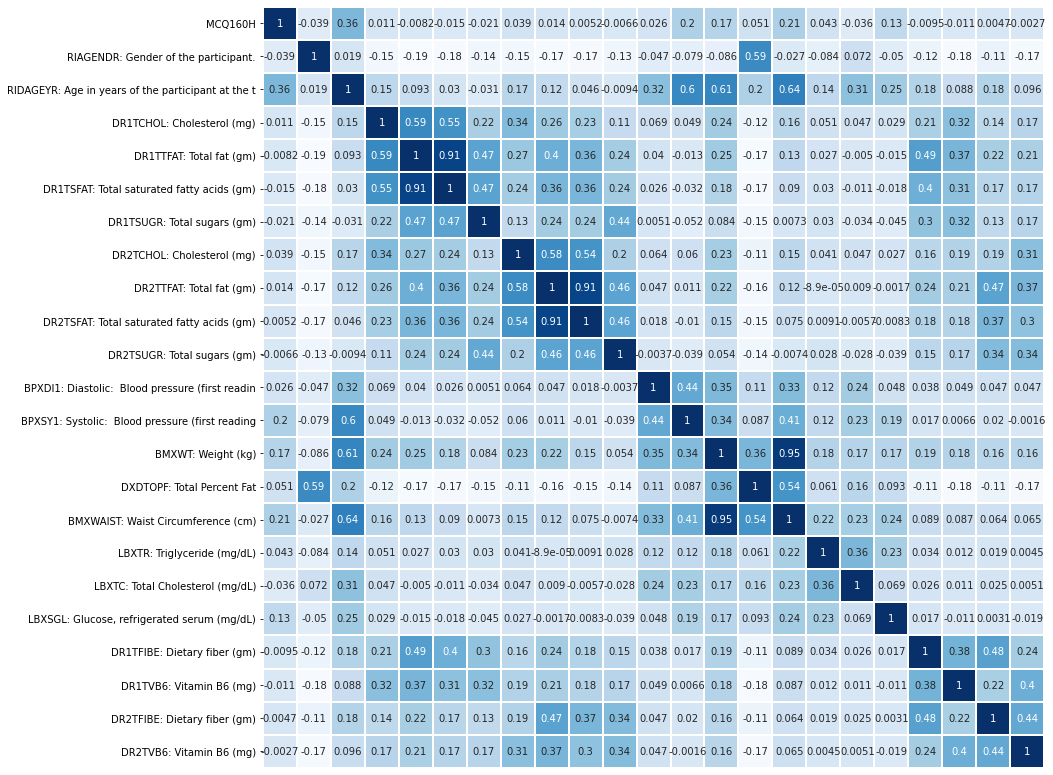

In [20]:
# Let's check the correlations

# 1) We pull the variables names from our vardata object
features_names = vardata.vars_descr_detector(list(dataset.df.columns), 40, True)

# 2) We create the plotter object
plotter = vi.eda_plotter
# 3) Now we use the correlation_matrix method
fig = plotter.correlation_matrix(dataset.df, features_names, figsize = (14, 14))

# To save all the plots as images later
health_reports_path = fo.path_to_folder(2, "reports" + sep + "health")
# Saving plot
#plt.savefig(health_reports_path + "Correlation_matrix.pdf", format = "pdf")

Well, it looks like our chosen independent variables are not quite linearly related with having any cardiovascular disease.
Let's continue the analysis though: Outliers

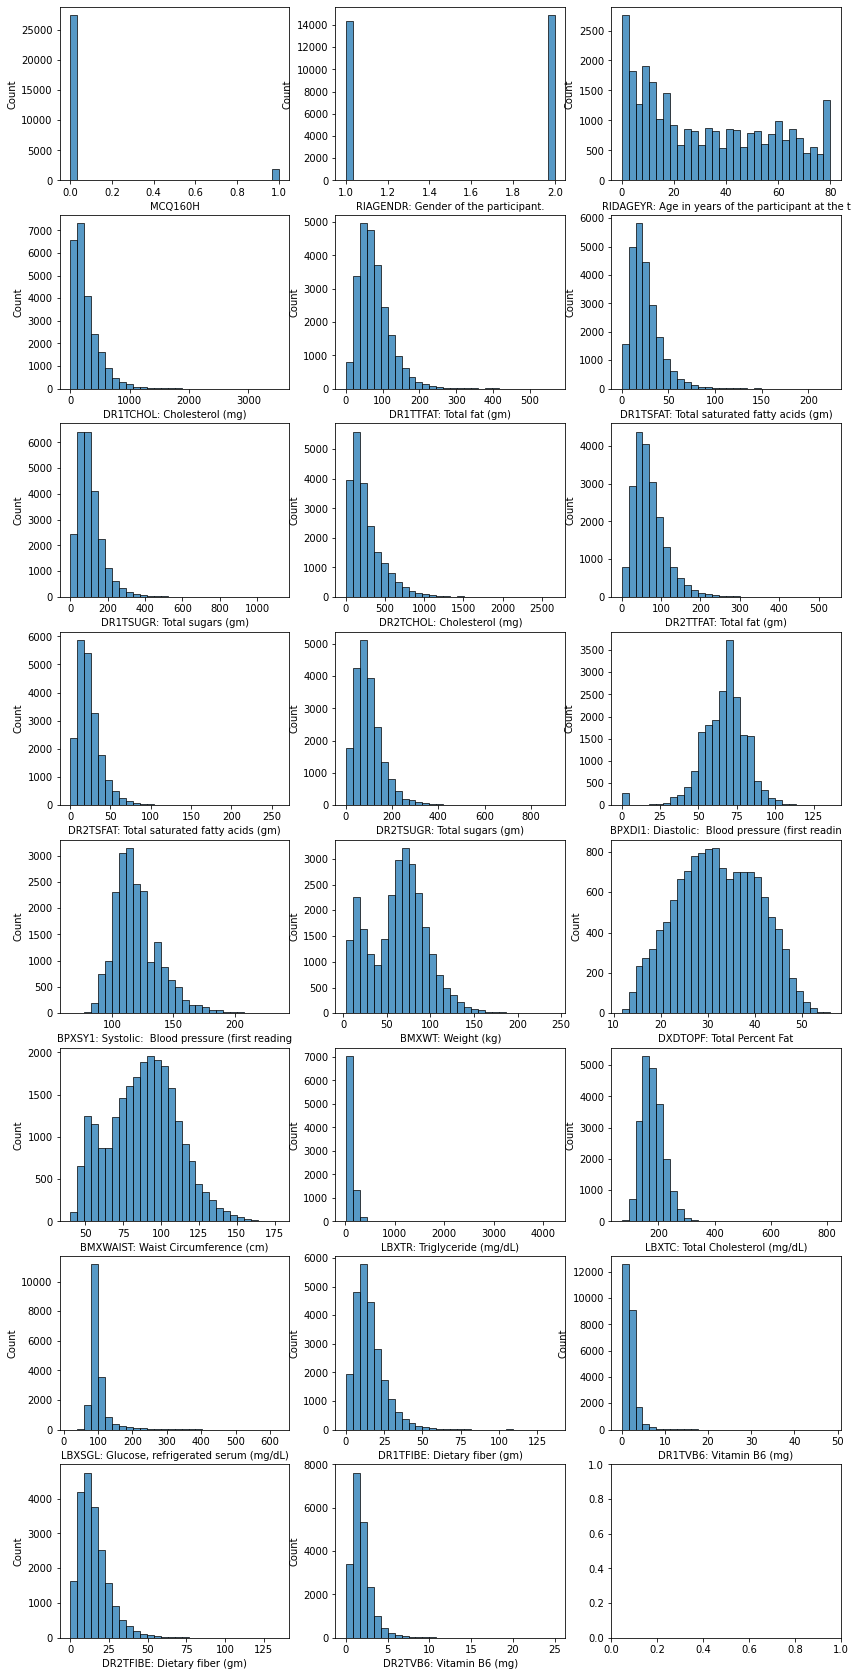

In [21]:
# For this, we will continue to use the plotter object we created
# In this case, we want to see the distribution of the variables
fig2 = plotter.multi_axes_plotter(dataset.df, features_names, 3, "stripplot", (14, 30))
#plt.savefig(health_reports_path + "Distribution_plots.pdf", format = "pdf")

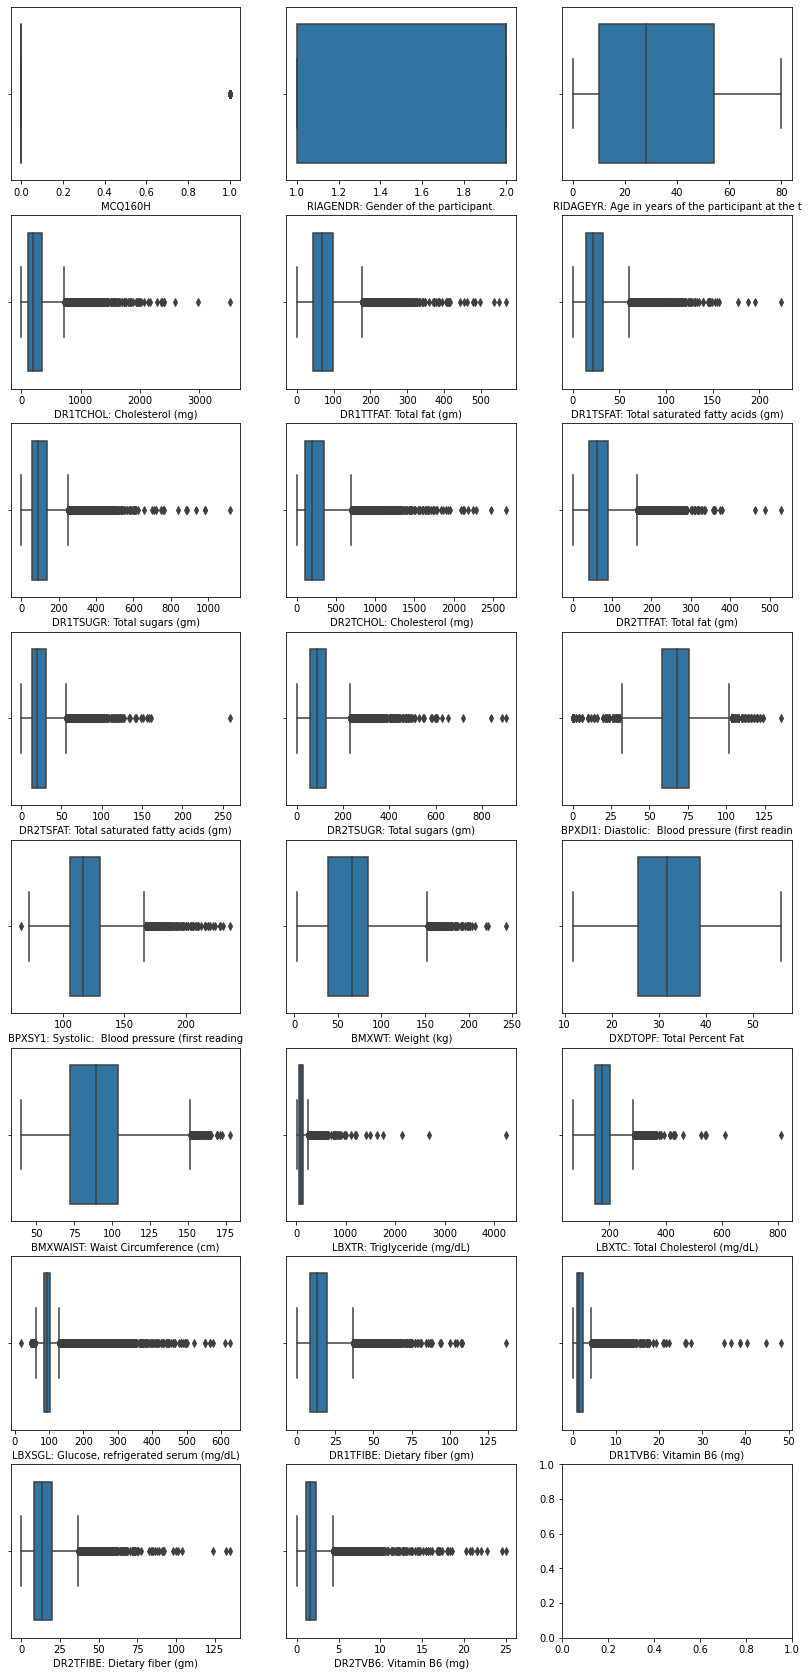

In [22]:
# Let's plot all the variables again, but now using the boxplot graph
# This will give us some extra insights on the data
fig3 = plotter.multi_axes_plotter(dataset.df, features_names, 3, "box", (14, 30))
#plt.savefig(health_reports_path + "Box_plots.pdf", format = "pdf")

Well, we have quite a few outliers

To keep in mind: since some of the independent variables are highly correlated, it's likely for them to have the same observations as outliers. For instance, DR1TTFAT and DR1STFAT are likely to have same participants as outliers

So, by removing the outliers from one of the correlated columns, we are cleaning the other one at the same time


In [25]:
# Let's do an example
DR1TTFAT_outliers = dataset.df[dataset.df.DR1TTFAT > 200]

print("full dataframe shape:", dataset.df.shape)
print("filtered dataframe shape:", DR1TTFAT_outliers.shape)
print("\nFull dataframe target values:")
print(dataset.df.iloc[:, 0].value_counts())
print("\nFiltered dataframe target values:")
print(DR1TTFAT_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(DR1TTFAT_outliers.isna().sum())

full dataframe shape: (29213, 23)
filtered dataframe shape: (458, 23)

Full dataframe target values:
0    27371
1     1842
Name: MCQ160H, dtype: int64

Filtered dataframe target values:
0    432
1     26
Name: MCQ160H, dtype: int64

NaNs:
MCQ160H       0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL      0
DR1TTFAT      0
DR1TSFAT      0
DR1TSUGR      0
DR2TCHOL     66
DR2TTFAT     66
DR2TSFAT     66
DR2TSUGR     66
BPXDI1       38
BPXSY1       38
BMXWT         4
DXDTOPF     149
BMXWAIST     10
LBXTR       269
LBXTC        27
LBXSGL       44
DR1TFIBE      0
DR1TVB6       0
DR2TFIBE     66
DR2TVB6      66
dtype: int64


In [32]:
dataset.reset_dataset()
test = dataset.df
mcq160b = test[test["MCQ160B"] != np.nan]
mcq160c = test[test["MCQ160C"] != np.nan]
mcq160d = test[test["MCQ160D"] != np.nan]
mcq160e = test[test["MCQ160E"] != np.nan]
mcq160f = test[test["MCQ160F"] != np.nan]

final_test = pd.merge(mcq160b, mcq160c, how = "outer", left_index = True, right_index = True)
mcq160c.MCQ160C

SEQN
83732     0.0
83733     0.0
83734     0.0
83735     0.0
83736     0.0
         ... 
102952    0.0
102953    0.0
102954    0.0
102955    NaN
102956    0.0
Name: MCQ160C, Length: 29213, dtype: float64

As we can see, there are quite a few positive cases (MCQ010 == 1) within the fat outliers. This means, by removing the outliers we would also remove valuable information for our model to detect when someone is likely to have asthma.

We have to keep in mind that our data is already quite imbalanced, so the more positive target values we keep, the better.

Let's do a simple calculation to see if it's worth to remove the outliers here mentioned.

The ratio of positive/data in out full dataset is = 1842 / (1842 + 23819) ~ 0.15225

If the ratio in the outliers is below that number, it would mean that we are removing more negative than positive ones, so it could be worth. However, for this batch this is not the case:
85 / (374 + 85) ~ 0.18518